# Part 1


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

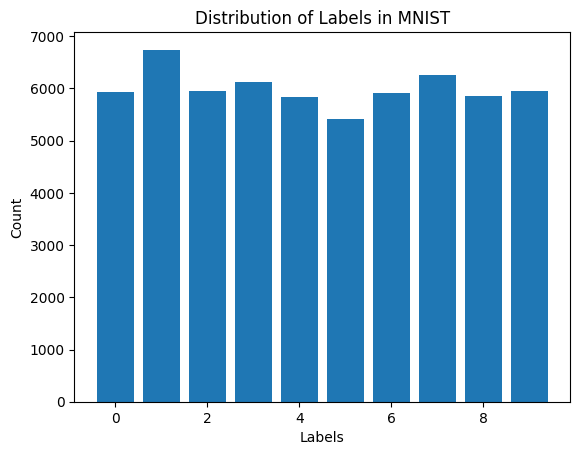

In [3]:
label_counts = torch.zeros(10)
for images, labels in trainloader:
    label_counts += torch.bincount(labels, minlength=10)

plt.bar(range(10), label_counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels in MNIST')
plt.show()

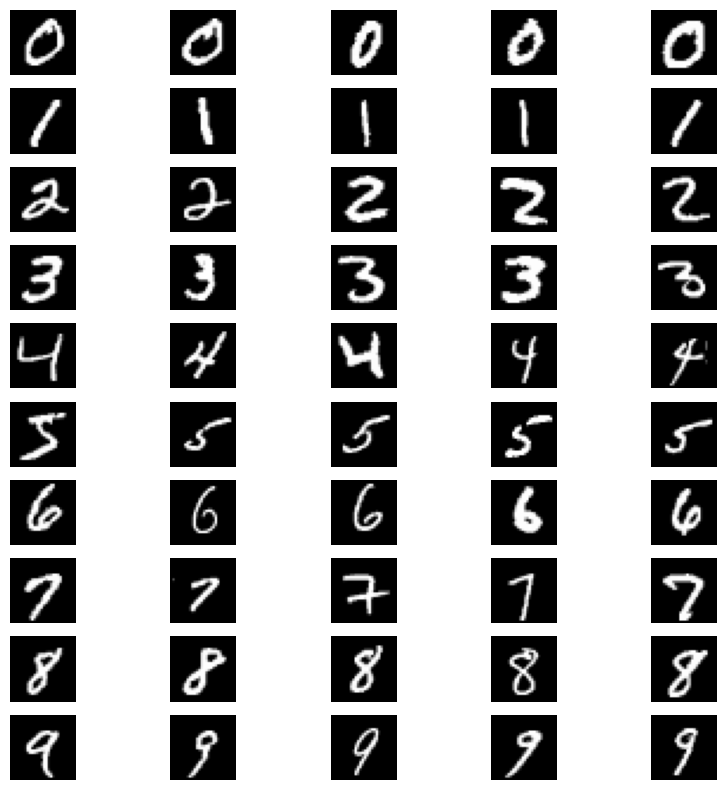

In [4]:
fig, axs = plt.subplots(10, 5, figsize=(10, 10))
for i in range(10):
    class_samples = [image for image, label in trainset if label == i]
    for j in range(5):
        axs[i, j].imshow(class_samples[j][0], cmap='gray')
        axs[i, j].axis('off')

In [5]:
class_counts = label_counts.numpy()
class_imbalance = class_counts / np.sum(class_counts)
print("Class Imbalance:")
for i in range(10):
    print(f"Class {i}: {class_imbalance[i]:.2%}")

Class Imbalance:
Class 0: 9.87%
Class 1: 11.24%
Class 2: 9.93%
Class 3: 10.22%
Class 4: 9.74%
Class 5: 9.04%
Class 6: 9.86%
Class 7: 10.44%
Class 8: 9.75%
Class 9: 9.92%


In [6]:
total_samples = len(trainset)
train_size = int(0.8 * total_samples)
val_size = total_samples - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])
testset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
# testset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [7]:
import torch.nn as nn

def visualize_feature_maps(model, layer_idx, input_image):
    activation = None
    def hook_fn(module, input, output):
        nonlocal activation
        activation = output.detach()

    layer = model.features[layer_idx]
    hook_handle = layer.register_forward_hook(hook_fn)

    with torch.no_grad():
        model(input_image.unsqueeze(0))  # Pass the input through the model

    feature_map = activation.squeeze(0)
    hook_handle.remove()

    # Visualize the feature map
    plt.imshow(feature_map[layer_idx], cmap='viridis')
    plt.title(f"Feature Map for Layer {layer_idx}")
    plt.axis('off')
    plt.show()

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(64 * 7 * 7, 10)  # 7x7 is the size after two max-pooling layers

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(x)
        x = self.fc1(x)
        return x


In [9]:
model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

train_losses, val_losses, train_acc, val_acc = [], [], [], []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(running_loss / len(trainloader))
    train_acc.append(train_accuracy)
    
    # Validation
    with torch.no_grad():
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        for data in valloader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
        
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss / len(valloader))
        val_acc.append(val_accuracy)
        
        model.train()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc[-1]:.2f}%')



Epoch 1/10, Train Loss: 0.1938, Train Acc: 94.14%, Val Loss: 0.0649, Val Acc: 98.07%
Epoch 2/10, Train Loss: 0.0754, Train Acc: 97.63%, Val Loss: 0.0385, Val Acc: 98.88%
Epoch 3/10, Train Loss: 0.0595, Train Acc: 98.10%, Val Loss: 0.0334, Val Acc: 98.97%
Epoch 4/10, Train Loss: 0.0514, Train Acc: 98.36%, Val Loss: 0.0268, Val Acc: 99.24%
Epoch 5/10, Train Loss: 0.0447, Train Acc: 98.58%, Val Loss: 0.0225, Val Acc: 99.39%
Epoch 6/10, Train Loss: 0.0427, Train Acc: 98.65%, Val Loss: 0.0218, Val Acc: 99.41%
Epoch 7/10, Train Loss: 0.0401, Train Acc: 98.70%, Val Loss: 0.0211, Val Acc: 99.37%
Epoch 8/10, Train Loss: 0.0374, Train Acc: 98.75%, Val Loss: 0.0180, Val Acc: 99.49%
Epoch 9/10, Train Loss: 0.0337, Train Acc: 98.93%, Val Loss: 0.0128, Val Acc: 99.65%
Epoch 10/10, Train Loss: 0.0315, Train Acc: 98.95%, Val Loss: 0.0124, Val Acc: 99.67%


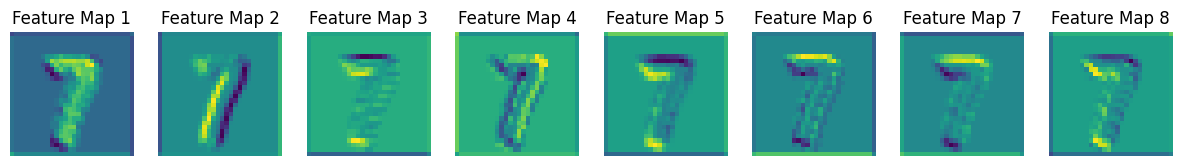

Training Losses: [0.19381618483571897, 0.07535518889751301, 0.05948620603190485, 0.05142369614241383, 0.04474888630239899, 0.042718801585990174, 0.04009702431592422, 0.037384237805876616, 0.03368780373579273, 0.03148680526075879]
Validation Losses: [0.06489523123216598, 0.038540201485801014, 0.03339420732059962, 0.02682397843036984, 0.022452651717182387, 0.02176732918466788, 0.02113985518248073, 0.018024978533968023, 0.012782544236967062, 0.012433797713961116]
Training Accuracy: [94.14166666666667, 97.63, 98.09833333333333, 98.36, 98.585, 98.64833333333333, 98.705, 98.75166666666667, 98.92666666666666, 98.95166666666667]
Validation Accuracy: [98.06666666666666, 98.875, 98.975, 99.24166666666666, 99.39166666666667, 99.40833333333333, 99.36666666666666, 99.49166666666666, 99.65, 99.675]


In [10]:
import matplotlib.pyplot as plt

def plot_feature_maps(layer_idx, num_feature_maps, input_image):
    model.eval()
    activation = None
    
    def hook_fn(module, input, output):
        nonlocal activation
        activation = output

    if layer_idx == 1:
        layer = model.conv1
    elif layer_idx == 2:
        layer = model.conv2
    else:
        print("Invalid layer index.")
        return

    hook_handle = layer.register_forward_hook(hook_fn)

    with torch.no_grad():
        model(input_image.unsqueeze(0))

    feature_maps = activation.squeeze(0)
    hook_handle.remove()

    # Plot the feature maps
    plt.figure(figsize=(15, 5))
    for i in range(num_feature_maps):
        plt.subplot(1, num_feature_maps, i + 1)
        plt.imshow(feature_maps[i].cpu(), cmap='viridis')
        plt.title(f"Feature Map {i + 1}")
        plt.axis('off')
    plt.show()

sample_image, _ = trainset[0]
plot_feature_maps(layer_idx=1, num_feature_maps=8, input_image=sample_image)


print("Training Losses:", train_losses)
print("Validation Losses:", val_losses)
print("Training Accuracy:", train_acc)
print("Validation Accuracy:", val_acc)


# Part 2

In [11]:
from scipy.io import loadmat

data = loadmat('mnist-with-awgn.mat')

# print(data)
variable_names = [key for key in data.keys()]
print(variable_names)
# my_variable_data = data['my_variable']

# print(my_variable_data)
train_x=data["train_x"]
train_y=data["train_y"]
test_x=data["test_x"]
test_y=data["test_y"]

['__header__', '__version__', '__globals__', 'train_x', 'test_x', 'train_y', 'test_y']


In [12]:
val_x=train_x[50000:]
val_y=train_y[50000:]
train_y=train_y[:50000]
train_x=train_x[:50000]

In [13]:
import torch
from torch.utils.data import DataLoader, TensorDataset
batch_size = 16

train_dataset = TensorDataset(torch.Tensor(train_x), torch.Tensor(train_y))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(torch.Tensor(test_x), torch.Tensor(test_y))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(torch.Tensor(val_x), torch.Tensor(val_y))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [14]:
import torch.nn.functional as F

model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(10):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        # break
        # print(inputs.shape)
        inputs=inputs.reshape(16,1,28,28)

        # break
        outputs = model(inputs)
        log_probs = F.log_softmax(outputs, dim=1)
        loss = criterion(log_probs, labels)
        # loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        true=[]
        for i in labels:
            # print(i)
            for j in range(len(i)):
                if(i[j]==1):
                    true.append(j)
                    break
        # print(true)
        true=torch.tensor(true)
        # print(true)
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        # print(predicted)
        correct_train += (predicted == true).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            # inputs=inputs.reshape(32,1,28,28)
            # outputs = model(inputs)
            # loss = criterion(outputs, labels.long())
            inputs=inputs.reshape(16,1,28,28)

        # break
            outputs = model(inputs)
            log_probs = F.log_softmax(outputs, dim=1)
            loss = criterion(log_probs, labels)
            # loss = criterion(outputs, labels)
            true=[]
            for i in labels:
                # print(i)
                for j in range(len(i)):
                    if(i[j]==1):
                        true.append(j)
                        break
            # print(true)
            true=torch.tensor(true)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == true).sum().item()

    val_loss = running_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}] - '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

print(f'Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%')
print(f'Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.2f}%')

Epoch [1/5] - Train Loss: 1.1000, Train Accuracy: 66.54% - Validation Loss: 0.3972, Validation Accuracy: 88.62%
Epoch [2/5] - Train Loss: 0.6726, Train Accuracy: 77.68% - Validation Loss: 0.3322, Validation Accuracy: 90.67%
Epoch [3/5] - Train Loss: 0.5335, Train Accuracy: 82.65% - Validation Loss: 0.1960, Validation Accuracy: 93.73%
Epoch [4/5] - Train Loss: 0.3988, Train Accuracy: 87.40% - Validation Loss: 0.1631, Validation Accuracy: 94.70%
Epoch [5/5] - Train Loss: 0.3553, Train Accuracy: 88.71% - Validation Loss: 0.1448, Validation Accuracy: 95.49%
Epoch [6/5] - Train Loss: 0.3255, Train Accuracy: 89.78% - Validation Loss: 0.1568, Validation Accuracy: 95.03%
Epoch [7/5] - Train Loss: 0.3185, Train Accuracy: 89.89% - Validation Loss: 0.1357, Validation Accuracy: 95.87%
Epoch [8/5] - Train Loss: 0.3032, Train Accuracy: 90.42% - Validation Loss: 0.1484, Validation Accuracy: 95.39%
Epoch [9/5] - Train Loss: 0.2811, Train Accuracy: 91.25% - Validation Loss: 0.1360, Validation Accuracy:

In [15]:
from sklearn.metrics import classification_report

true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.reshape(16, 1, 28, 28)
        outputs = model(inputs)
        true = []
        for i in labels:
            for j in range(len(i)):
                if i[j] == 1:
                    true.append(j)
                    break
        true = torch.tensor(true)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(true.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

report = classification_report(true_labels, predicted_labels)

print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.97      0.98      0.98      1135
           2       0.97      0.95      0.96      1032
           3       0.98      0.96      0.97      1010
           4       0.97      0.97      0.97       982
           5       0.96      0.97      0.96       892
           6       0.95      0.97      0.96       958
           7       0.96      0.96      0.96      1028
           8       0.94      0.95      0.95       974
           9       0.95      0.94      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



# Part 3

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()  # Sigmoid for pixel values (0-1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

autoencoder = Autoencoder()
criterion = nn.MSELoss()  # Mean Squared Error loss for reconstruction
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)